In [1]:
#basics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#text process
import nltk
import unidecode
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Classification
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Decision tree
import graphviz
import pydotplus
from sklearn.tree import DecisionTreeClassifier,export_graphviz




# Instala dependências

In [2]:
%pip install graphviz
%pip install pydotplus

You should consider upgrading via the '/home/igor/Desktop/UFES/6 Período-EART/Data Science/TP/datascience_env/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/home/igor/Desktop/UFES/6 Período-EART/Data Science/TP/datascience_env/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


# Processamento dos dados

Como existem dados textuais podemos usar as funções já utilizadas no trabalho anterior




In [3]:
with open('./data/dataset.csv', encoding="utf8") as file:
    df = pd.read_csv(file)
    
df.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,0
1,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
2,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0
3,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0
4,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


## Separação treino e teste

Ocorre a separação do dataset em treino em teste na proporção 80% pra 20%, respectivamente, além disso, a criação dos mesmo é feito de forma aleatória para não criarmos dataset enviesados, além de estar estratificado com o dataset.

In [4]:
from sklearn.model_selection import train_test_split

df_train_raw, df_test_raw = train_test_split(df, test_size=0.2, shuffle=True, random_state=42, stratify=df['target'])

# Trainset

In [5]:
print(df_train_raw.shape)
df_train_raw.head()

(8700, 5)


,id,keyword,location,text,target
8491,8491,screamed,NaN,i dont even remember slsp happening i just rem...,0
7178,7178,mudslide,Edinburgh,@hazelannmac ooh now I feel guilty about wishi...,0
2423,2423,collide,planeta H2o,Soultech - Collide (Club Mix) http://t.co/8xIx...,0
10612,10612,wounded,NaN,Police Officer Wounded Suspect Dead After Exch...,1
10791,10791,wrecked,Sunny Southern California,Cramer: Iger's 3 words that wrecked Disney's s...,0


[Text(0, 0, 'Non Desaster'), Text(1, 0, 'Desaster')]

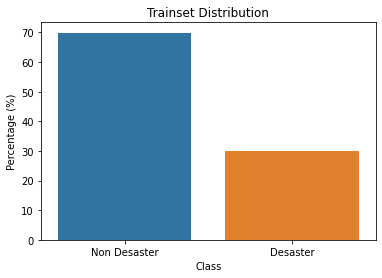

In [7]:
ax = sns.barplot(x='target', y='target',data = df_train_raw, estimator=lambda  x: len(x)/len(df_train_raw)*100)

ax.set_title('Trainset Distribution')
ax.set_ylabel('Percentage (%)')
ax.set_xlabel('Class')
ax.set_xticklabels(["Non Desaster","Desaster"])

# Testset

In [8]:
print(df_test_raw.shape)
df_test_raw.head()

(2176, 5)


,id,keyword,location,text,target
5322,5322,fire,NaN,My asshole is on fire https://t.co/Y3FO0gHg8t,0
5482,5482,flames,St. Patrick's Purgatory,@TadhgTGMTEL dude was just smoking and the fuc...,1
7739,7739,panicking,South Florida,People are finally panicking about cable TV ht...,0
104,104,accident,"Walker County, Alabama",Reported motor vehicle accident in Curry on He...,1
5597,5597,flood,New York,12' 72W CREE LED Work Light Bar Alloy Spot Flo...,0


[Text(0, 0, 'Non Desaster'), Text(1, 0, 'Desaster')]

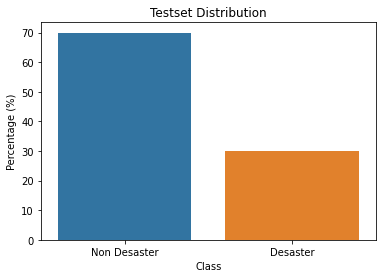

In [9]:
ax = sns.barplot(x='target', y='target',data = df_test_raw, estimator=lambda  x: len(x)/len(df_test_raw)*100)

ax.set_title('Testset Distribution')
ax.set_ylabel('Percentage (%)')
ax.set_xlabel('Class')
ax.set_xticklabels(["Non Desaster","Desaster"])

## Limpeza dos textos dos tweets

Um coisa interessante de se pensar é que os dados textuais se dão através de textos escritos por pessoas em sua rede social tweeter e podem existir erros de digitação assim é importante tentar corrigir as palavras mal escritas. Para isso podemos usar a biblioteca spell checker.

In [7]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/igor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/igor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/igor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/igor/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Reutilizando funções do trabalho prático

In [8]:
def remove_specials(tokens):
    return [unidecode.unidecode(word) for word in tokens]

def remove_punctuation(tokens):
    table = str.maketrans("","",string.punctuation)
    return [w.translate(table) for w in tokens]

def array_lower(tokens):
    return [w.lower() for w in tokens]

def remove_no_words(tokens):
    return [word for word in tokens if word.isalpha()]

def remove_stop_words(tokens):
    stop_words = set(stopwords.words('english'))
    return [w for w in tokens if not w in stop_words]


def text_cleaner(string):
   
    # Dividindo texto em tokens
    string = word_tokenize(string)
    #df_text_column = df_text_column.apply(word_tokenize)
    
    # Convertendo texto para minusculo
    string = array_lower(string)
    #df_text_column = df_text_column.apply(array_lower)

    # Removendo pontuação
    string = remove_punctuation(string)
    #df_text_column = df_text_column.apply(remove_punctuation)
    
    # Removendo caracteres especiais
    string = remove_specials(string)
    #df_text_column = df_text_column.apply(remove_specials)

    # Removendo tokens que não sao palavras
    string = remove_no_words(string)
    #df_text_column = df_text_column.apply(remove_no_words)

    # Removendo tokens que são stop words
    string = remove_stop_words(string)
    #df_text_column = df_text_column.apply(remove_stop_words)
    
    return string

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

#do_nothing = lambda x: x
N_COMPONENTS = 1000 #Vimos com o PCA diminuindo metade das featues tinha uma variancia explicada alta

wordnet_lemmatizer = WordNetLemmatizer()
lemmazation = lambda words: [wordnet_lemmatizer.lemmatize(tk) for tk in words]


tfidf = TfidfVectorizer(tokenizer = lemmazation,lowercase=False, preprocessor=text_cleaner, ngram_range=(1, 2),min_df=10,max_df=0.95)

text_process_pipe = Pipeline([
                             ("tfidf",tfidf),
                             ("pca", TruncatedSVD(n_components=N_COMPONENTS))
                             ])


In [10]:
X_train = text_process_pipe.fit_transform(df_train_raw['text'])
y_train = df_train_raw['target']

In [11]:
X_test = text_process_pipe.transform(df_test_raw['text'])
y_test = df_test_raw['target']

In [12]:
print(f"Total variance explained: {text_process_pipe['pca'].explained_variance_ratio_.sum()*100:.2f}%")

Total variance explained: 89.69%


In [13]:
#Transforma as features em um Dataframe
X_train_view = pd.DataFrame(data=X_train, columns=list(range(N_COMPONENTS)))
X_train_view.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.025295,0.105841,-0.027944,-0.050739,-0.045841,0.099896,0.055840,0.003640,-0.027016,-0.047279,...,0.009130,-0.031612,0.008314,-0.026059,-0.030787,-0.029119,-0.014066,0.000446,0.015456,0.022039
1,0.016611,0.052925,-0.027295,-0.042237,-0.049774,0.103705,0.048638,-0.000676,-0.028889,-0.050378,...,0.026900,-0.003844,0.012561,0.046887,0.034202,0.008882,-0.007290,-0.012023,0.033075,0.000760
2,0.155613,-0.034970,-0.014617,0.011201,-0.005577,0.007897,0.000354,0.011519,0.002101,-0.002696,...,0.028399,0.012248,0.004787,-0.001948,-0.005008,-0.013717,-0.041755,0.022451,0.011116,-0.008722
3,0.083755,0.000254,-0.007812,-0.012649,0.020673,-0.026572,0.023222,0.000115,-0.001663,0.011030,...,0.000526,0.009760,0.004237,0.016780,0.005701,0.005176,-0.004860,0.010427,0.015806,-0.010312
4,0.124029,-0.016515,-0.015993,-0.000771,-0.004137,-0.002328,0.015664,0.003421,0.022498,-0.002296,...,-0.005132,0.002196,0.000699,0.006408,-0.007962,0.001015,0.000496,-0.002875,-0.000530,-0.001163


Text(0, 0.5, 'Variancia explicada')

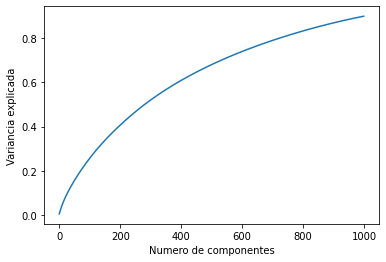

In [14]:
plt.plot(np.cumsum(text_process_pipe['pca'].explained_variance_ratio_))
plt.xlabel('Numero de componentes')
plt.ylabel('Variancia explicada')

# Analise exploratoria de cada classe

Os dados possuem 2 classes são elas:

0 - Tweets sobre desastres que são fake (Não Desastre)

1 - Tweets sobre desastres que são reais (Desastre)

[Text(0, 0, 'Não Desastre'), Text(1, 0, 'Desastre')]

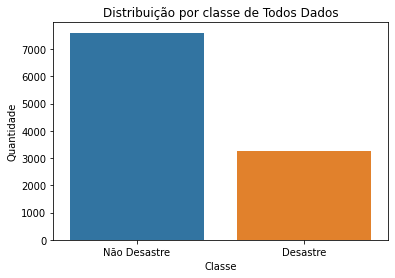

In [15]:
ax = sns.countplot(x='target',data = df)

ax.set_title('Distribuição por classe de Todos Dados')
ax.set_ylabel('Quantidade')
ax.set_xlabel('Classe')
ax.set_xticklabels(["Não Desastre","Desastre"])

Podemos comparar algumas caracteristicas do texto, como tamanho do texto e a quantidade de tokens geradas por cada.

Text(0.5, 1.05, 'Distribuição da quantidade de caracteres do tweet por classe')

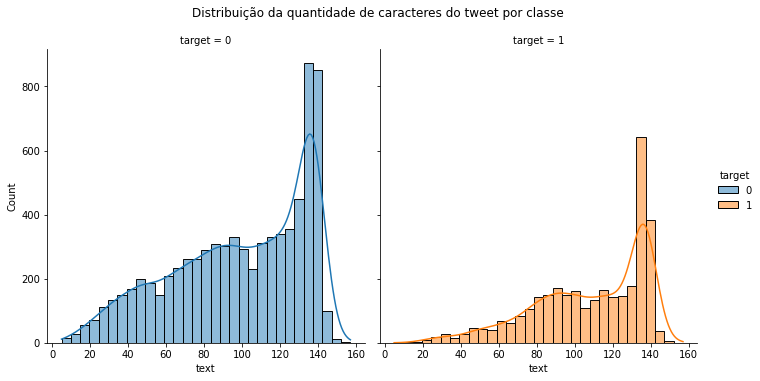

In [16]:
ax = sns.displot(x=df['text'].str.len(),data = df,col='target',hue='target',kde=True)

ax.fig.suptitle('Distribuição da quantidade de caracteres do tweet por classe',y=1.05)

# Classificadores

In [17]:
def test_classifier(classifier,params,X_train,y_train,X_test,y_test):
    params = params
    clf = GridSearchCV(classifier, params, n_jobs = -1,cv=5)
    clf.fit(X_train, y_train)
    
    print(clf.best_params_)
    
    y_predicted = clf.predict(X_test)
    
    print(classification_report(y_test, y_predicted))
    ConfusionMatrixDisplay.from_predictions(y_test, y_predicted);
    
    return clf

## Knn

{'n_neighbors': 5}
              precision    recall  f1-score   support

           0       0.75      0.93      0.83      1503
           1       0.66      0.31      0.42       673

    accuracy                           0.74      2176
   macro avg       0.71      0.62      0.62      2176
weighted avg       0.72      0.74      0.70      2176



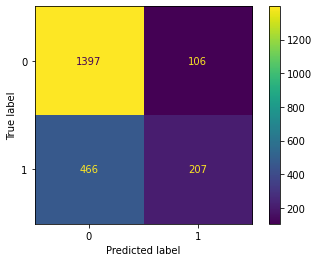

In [18]:
params = {'n_neighbors': [3,5,7,11,13]}

knn = test_classifier(KNeighborsClassifier(),params,X_train,y_train,X_test,y_test)

## Decision Tree

{'criterion': 'gini', 'max_depth': 5}
              precision    recall  f1-score   support

           0       0.74      0.88      0.80      1503
           1       0.54      0.31      0.39       673

    accuracy                           0.70      2176
   macro avg       0.64      0.60      0.60      2176
weighted avg       0.68      0.70      0.68      2176



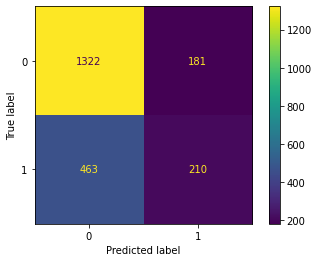

In [19]:
params = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

dt = test_classifier(DecisionTreeClassifier(),params,X_train,y_train,X_test,y_test)

In [20]:
dot_data = export_graphviz(dt.best_estimator_, out_file=None,
                     filled=True, rounded=True,  
                     special_characters=True)

graph = graphviz.Source(dot_data)  
#graph.render("dt-vis",view = True)
#graph

## Random Forest

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
#
# params = {'bootstrap': [True, False],
#           'max_depth': [10, 20, 30, None],
#           'max_features': ['auto', 'sqrt']}
#
#
# rf = test_classifier(RandomForestClassifier(),params,X_train,y_train,X_test,y_test)

KeyboardInterrupt: 